# Image segmentation with U-Nets #

The task at hand is very similar to object detection, but instead of placing bounding boxes around objects, semantic image segmentation allows you to predict a precise "mask" for every object in the image by labeling each pixel in the image with its corresponding class.

Below, an example that shows a segmented image:

![](https://drive.google.com/uc?export=view&id=1LQE92P-npc_3Kzr48VrLzjeEAjPYUXpI)

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data loading and processing #

Data is stored in 2 folders, *DataRGB* and *DataMask*. As infered from their names, *DataRGB* contains raw images, whereas *DataMask* contains the segmented version of each raw image.

In [3]:
import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

image_path = '/content/drive/MyDrive/semantic-segmentation/data/CameraRGB/'
mask_path = '/content/drive/MyDrive/semantic-segmentation/data/CameraMask/'
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

Below is a sample from the dataset

<ipython-input-4-4ec99b071fd9>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-4-4ec99b071fd9>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

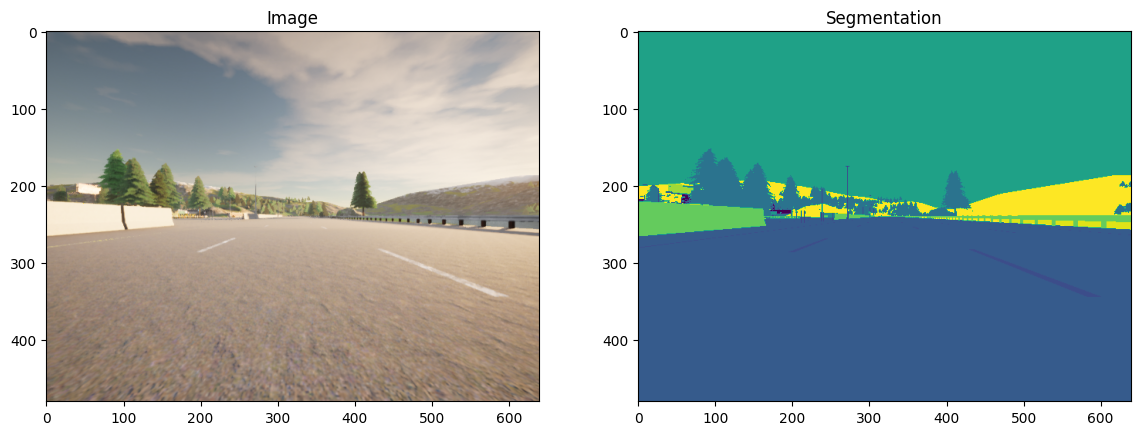

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

# Split dataset into unmasked and masked images #

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/semantic-segmentation/data/CameraMask/000028.png'>)
tf.Tensor(b'/content/drive/MyDrive/semantic-segmentation/data/CameraRGB/010570.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/semantic-segmentation/data/CameraMask/010570.png', shape=(), dtype=string)


In [6]:
print(len(dataset))

1060


# Preprocess data
Here, we use ```tf.image.convert_image_dtype```.

- It casts all values between 0 and 1, so we need not divide by 255.
- We resize all images to size (96,128).

In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

# U-Net Architecture #

![](https://drive.google.com/uc?export=view&id=1zSu7By8eHf9CRjSS0jmGjm3MeyiQ6KSo)

U-Nets consist of 2 phases
- Downsampling (encoder phase)
- Upsampling (decoder phase)


# Encoder #

![](https://drive.google.com/uc?export=view&id=1riEUR9-eBscD3etT-yC6S4FCzTZIWJNy)

An encoder is a stack of various convolutional blocks.

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D
    if max_pooling:
        next_layer = MaxPooling2D()(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

# Decoder #

![](https://drive.google.com/uc?export=view&id=16w4eYEs6bzgobq5ZhYZQRWrnh2k35MUW)

A decoder does just the opposite of the encoder, it samples up and the increases the height and width of the volume.

Also, we will use the cached outputs of convolution blocks (during encoder phase) and concat them with upsample blocks.

This is a kind of "skip" connection, and helps to retain information from preivous layers.

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

# U_Net_model #

Make use of ```tf.keras.Model``` to instantiate. We have 5 levels of depth in this particular model.

`num_classes = 23` has been chosen to segment the images into at most 23 classes. This choice is based on the dataset.

In [10]:
def U_Net_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    U_Net model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, 0.3) # including dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters*16, 0.3, False)

    # expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Model Dimensions

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet = U_Net_model((img_height, img_width, num_channels))

In [12]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Loss function #

In semantic segmentation, we need as many masks as we have object classes. In the dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to (num_classes-1). The correct class is the layer with the higher probability.

Here, we will use sparse-categorical-crossentropy, since our outputs are not one-hot encoded. It is generally more efficient to use.

In [13]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Dataset Handling #

Here, we use a helping function to show an image and its true mask.

Adapted from Tensorflow documentation.

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Training #

In [15]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 649s 13s/step - loss: 1.8509 - accuracy: 0.4361
Epoch 2/5
34/34 [==============================] - 413s 12s/step - loss: 0.8810 - accuracy: 0.7486
Epoch 3/5
34/34 [==============================] - 403s 12s/step - loss: 0.6345 - accuracy: 0.8138
Epoch 4/5
34/34 [==============================] - 409s 12s/step - loss: 0.5260 - accuracy: 0.8478
Epoch 5/5
34/34 [==============================] - 405s 12s/step - loss: 0.4492 - accuracy: 0.8720


# Create Mask #

Here, we use `tf.argmax` to find the class with highest probability, then assign each pixel to its dominant class.

Adapted from Tensorflow documentation.

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

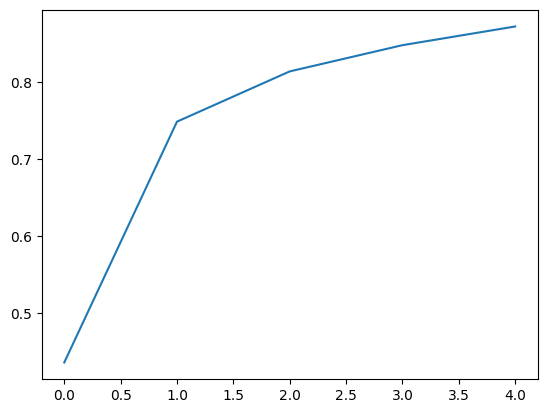

In [17]:
plt.plot(model_history.history["accuracy"])

Below, is a function which displays the first image of each batch of the training set.

Adapted from Tensorflow documentation.

In [18]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 4s 4s/step


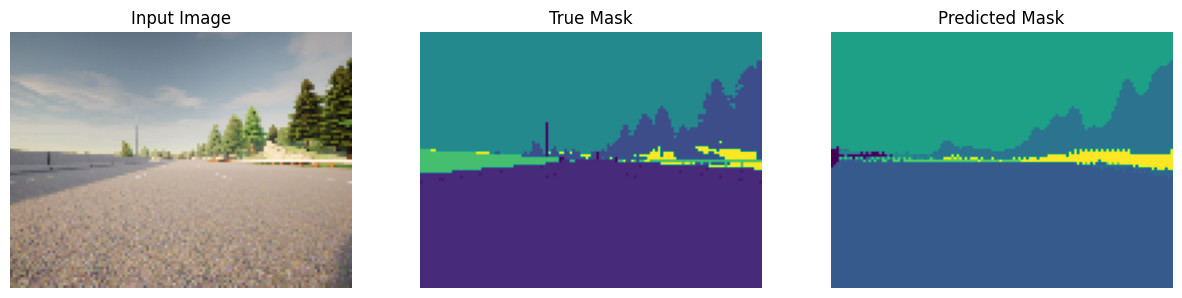

1/1 [==============================] - 4s 4s/step


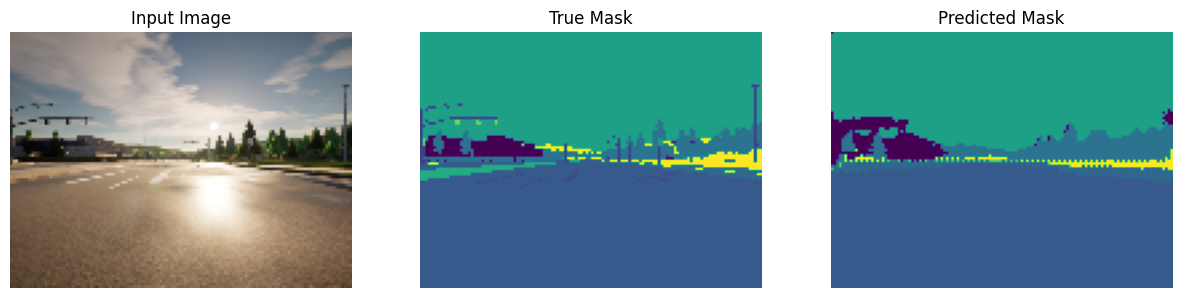

1/1 [==============================] - 3s 3s/step


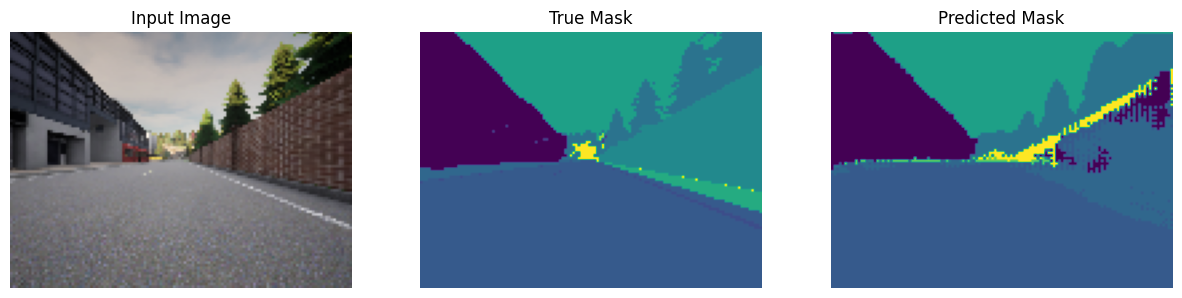

1/1 [==============================] - 3s 3s/step


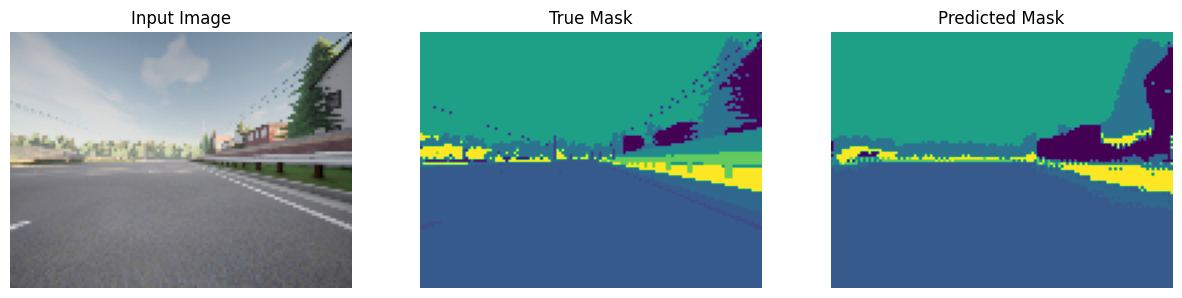

1/1 [==============================] - 4s 4s/step


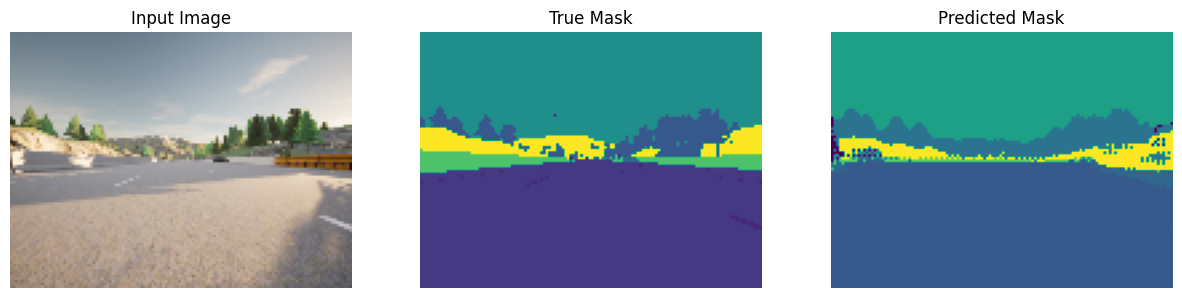

1/1 [==============================] - 3s 3s/step


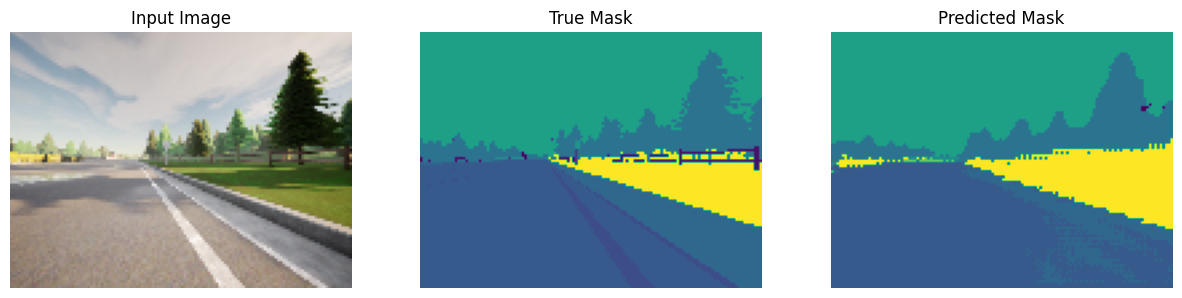

In [19]:
show_predictions(train_dataset, 6)